## Conformational clustering of ligand with respect to receptor

In this tutorial, we will perform and analyze conformational clustering of ligand with reference to the receptor using coordinate-based PCA. Here, receptor is a
G-Quadruplex DNA (G4DNA) and ligand is bound on top of the G4DNA. The oreintation of ligand is highly flexible and changes a lot during the simulations. Therefore,
clustering will enable the grouping of ligand conformations with reference to the G4DNA conformation.

#### Final Result:
<img src="https://raw.githubusercontent.com/rjdkmr/gmx_clusterByFeatures/master/docs/images/ligand-pca.png" width="1000"/>

#### Instructions to begin tutorial
* **Tutorial files**: The tutorial files can be downloaded from [here](https://figshare.com/ndownloader/files/55494827).
* **Extract the files**: `tar -zxvf ligand-pca.tar.gz`
* **Go to directory**: `cd ligand-pca`
* **Copy the Jupyter Notebook**: This notebook is available in the GitHub repo. Download and copy it from the github.


#### We will perform following steps:
1. PCA of the ligand coordinates with reference to G4DNA
2. Calculate projections on first five PCs
3. Clustering using first five PCs as the features 
4. Analysis of clusters


### 1. PCA of the ligand coordinates with reference to G4DNA

We will use GROMACS tools `gmx covar` to perform the PCA. Here, we will perform PCA of ligand coordinates while G4DNA will be superimposed on reference structure.
Therefore, it will capture the motions and orientations of ligand with respect to the G4DNA.

This step will calculate covariance matrix, eigenvectors and eigenvalues. By default, the eigenvectors are written in `eigenvec.trr` while eigenvalues are written in `eigenval.xvg` files.

**Note:**

1. **First index** group is Ligand without hydrogen atoms. Covariance matrix, eigenvectors and eigenvalues will be calculated for this group.
2. **Second index** group is of G4DNA's G-tetrads that are highly rigid during the simulations and serves here the reference for structure-fitting of the whole complex.

In [1]:
%%bash

echo 13 14 | gmx covar -s inputs/input.tpr -f inputs/trajectory.xtc -n inputs/input.ndx

                      :-) GROMACS - gmx covar, 2025.2 (-:

Executable:   /opt/gromacs-2025/bin/gmx
Data prefix:  /opt/gromacs-2025
Working dir:  /home/raj/workspace/gmx_clusterByFeatrues/tutorials/ligand-pca
Command line:
  gmx covar -s inputs/input.tpr -f inputs/trajectory.xtc -n inputs/input.ndx

Reading file inputs/input.tpr, VERSION 2016.5 (single precision)
Reading file inputs/input.tpr, VERSION 2016.5 (single precision)
Group     0 (         System) has   864 elements
Group     1 (            DNA) has   783 elements
Group     2 (            LIG) has    30 elements
Group     3 (              K) has    37 elements
Group     4 (             CL) has    14 elements
Group     5 (          Other) has    30 elements
Group     6 (            LIG) has    30 elements
Group     7 (              K) has    37 elements
Group     8 (             CL) has    14 elements
Group     9 (            Ion) has    51 elements
Group    10 (            LIG) has    30 elements
Group    11 (              K) h


Choose a group for the least squares fit
Selected 13: 'r_4-6_r_8-9_r_13-15_r_17-20_r_23-24_&_!O1P_O2P_P_O5'_C5'_C3'_C2'_C1'_O4'_O3'_H*'

Choose a group for the covariance analysis
Selected 14: 'LIG_&_!H*'


### 2. Calculate projections on first five PCs

We will use eigenvectors `eigenvec.trr` as input files to GROMACS tool `gmx anaeig` to calculate projection of first 5 eigenvectors on trajectory. These projections will be written into `proj.xvg` file by default.

In [2]:
%%bash

echo 13 14 | gmx anaeig -s inputs/input.tpr -f inputs/trajectory.xtc -n inputs/input.ndx -proj -first 1 -last 5

                      :-) GROMACS - gmx anaeig, 2025.2 (-:

Executable:   /opt/gromacs-2025/bin/gmx
Data prefix:  /opt/gromacs-2025
Working dir:  /home/raj/workspace/gmx_clusterByFeatrues/tutorials/ligand-pca
Command line:
  gmx anaeig -s inputs/input.tpr -f inputs/trajectory.xtc -n inputs/input.ndx -proj -first 1 -last 5

trr version: GMX_trn_file (single precision)
Read non mass weighted average/minimum structure with 21 atoms from eigenvec.trr
Read 63 eigenvectors (for 21 atoms)

Reading file inputs/input.tpr, VERSION 2016.5 (single precision)
Reading file inputs/input.tpr, VERSION 2016.5 (single precision)
Group     0 (         System) has   864 elements
Group     1 (            DNA) has   783 elements
Group     2 (            LIG) has    30 elements
Group     3 (              K) has    37 elements
Group     4 (             CL) has    14 elements
Group     5 (          Other) has    30 elements
Group     6 (            LIG) has    30 elements
Group     7 (              K) has    37


Note: the structure in inputs/input.tpr should be the same
      as the one used for the fit in gmx covar

Select the index group that was used for the least squares fit in gmx covar
Selected 13: 'r_4-6_r_8-9_r_13-15_r_17-20_r_23-24_&_!O1P_O2P_P_O5'_C5'_C3'_C2'_C1'_O4'_O3'_H*'

Select an index group of 21 elements that corresponds to the eigenvectors
Selected 14: 'LIG_&_!H*'



### Clustering using first five PCs as features

Now, we will perform clustering using [K-Means algorithm](https://en.wikipedia.org/wiki/K-means_clustering). One of the **drawback** of K-Means clustering is that the number of clusters should be known beforehand. To automate the decision about number of clusters, `gmx_clusterByFeatures` implements several [cluster metrics](https://gmx-clusterbyfeatures.readthedocs.io/en/latest/commands/cluster.html#cmetric-prior). We will use option `-cmetric ssr-sst` to use the [Elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering).

Following command will perform the clustering of conformations using first 5 PCs projection. Explanation of options are as follows:
* `-method kmeans`: Use K-Means clustering algorithm
* `-ncluster 10`: K-Means clustering will be performed for 1 upto 10 clusters times each time. Finally, based on `-ssrchange` option, final number of clusters will be automatically selected.
* `-cmetric ssr-sst`: Use Elbow method to decide final number of clusters.
* `-nfeature 5`: Take 5 feature from `feat proj.xvg` input file. Here it is projection of first 5 eigenvectors on the trajectory.
* `-sort features`: Sort the output clustered trajectory based on the distance in feature space from its central structure.
* `-fit2central`: Fit/Superimpose the conformation on cluster's central structure in output clustered trajectory.
* `-ssrchange 2`: Threshold (percentage) of change in SSR/SST ratio in Elbow method to automatically decide the number of clusters.
* `-cpdb clustered-trajs/central.pdb`: Dump central conformation of each cluster as a separate pdb file.
* `-fout clustered-trajs/cluster.xtc`: Dump conformations of each cluster as the separate trajectory file.
* `-plot pca_cluster.png`: Plot the feature-space (here, it is first 5 PCs from PCA) coloured by the clusters.

#### index group order

1. **First index** group - Output group of atoms in the central structures and clustered trajectories

2. **Second index** group - Group of atoms to calculate RMSD between central conformations of clusters as RMSD matrix, which is dumped in the **log file** with `-g` option. Here, it is Ligand without hydrogen atoms.
    
3. **Third index** group - Used for Superimposition by least-square fitting. ONLY used in separate clustered trajectories to superimpose conformations on the central structure. Here, it is G-tetrads of the G4DNA that are highly rigid. 


#### This command could take a long time to execute!
This command could take a long time to execute because it is writing output trajectory file for each cluster sorted by distance in feature-space. Therefore, it needs **to read input trajectory back-and-forth** many time to extract the conformations in sorted manner. **XTC** format is fast for **back-and-forth** reading, and it still could take long time to dump the output trajectories.

In [7]:
%%bash

# create a new folder to contain clustered trajectory and pdb files
mkdir clustered-trajs

echo 0 14 13 | gmx_clusterByFeatures cluster -s inputs/input.tpr -f inputs/trajectory.xtc -n inputs/input.ndx -feat proj.xvg \
               -method kmeans -nfeature 5 -cmetric ssr-sst -ncluster 10 -fit2central -sort features -cpdb clustered-trajs/central.pdb \
               -fout clustered-trajs/cluster.xtc -plot pca_cluster.png

 :-) GROMACS - gmx_clusterByFeatures cluster, 2025.0-dev-20250210-6949615-local (-:

Executable:   gmx_clusterByFeatures cluster
Data prefix:  /project/external/gmx_installed
Working dir:  /home/raj/workspace/gmx_clusterByFeatrues/tutorials/ligand-pca
Command line:
  'gmx_clusterByFeatures cluster' -s inputs/input.tpr -f inputs/trajectory.xtc -n inputs/input.ndx -feat proj.xvg -method kmeans -nfeature 5 -cmetric ssr-sst -ncluster 10 -fit2central -sort features -cpdb clustered-trajs/central.pdb -fout clustered-trajs/cluster.xtc -plot pca_cluster.png


         :-)  gmx_clusterByFeatures cluster (-:

             Author: Rajendra Kumar

       Copyright (C) 2018-2019  Rajendra Kumar


gmx_clusterByFeatures is a free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

gmx_clusterByFeatures is distributed in the hope that it

  Cluster Log output   

Command:
'gmx_clusterByFeatures cluster' -s inputs/input.tpr -f inputs/trajectory.xtc -n inputs/input.ndx -feat proj.xvg -method kmeans -nfeature 5 -cmetric ssr-sst -ncluster 10 -fit2central -sort features -cpdb clustered-trajs/central.pdb -fout clustered-trajs/cluster.xtc -plot pca_cluster.png

Choose a group for the output:
Selected 0: 'System'

Choose a group for clustering/RMSD calculation:
Selected 14: 'LIG_&_!H*'

Choose a group for fitting or superposition:
Selected 13: 'r_4-6_r_8-9_r_13-15_r_17-20_r_23-24_&_!O1P_O2P_P_O5'_C5'_C3'_C2'_C1'_O4'_O3'_H*'


 Input Trajectory dt = 10 ps



###########################################
########## NUMBER OF CLUSTERS : 1 ########
###########################################

Cluster-ID	TotalFrames
1		77637



###########################################
########## NUMBER OF CLUSTERS : 2 ########
###########################################

Cluster-ID	TotalFrames
1		45430
2		32207



##################################

Reading frame       6 time 237500.000   <string>:127: MatplotlibDeprecationWarning: The non_interactive_bk attribute was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use ``matplotlib.backends.backend_registry.list_builtin(matplotlib.backends.BackendFilter.NON_INTERACTIVE)`` instead.

Back Off! I just backed up clid.xvg to ./#clid.xvg.1#
Reading frame   77000 time 242190.000   
GROMACS reminds you: "XML is not a language in the sense of a programming language any more than sketches on a napkin are a language." (Charles Simonyi)





Cluster-ID	Central Frame	Total Frames 
1		19604		15300
2		40230		14284
3		50481		12634
4		57523		12045
5		16039		8607
6		6092		7989
7		23750		6778



Extracting coordinates of the central structure...


Calculating RMSD between central structures...


 Central structurs - RMSD matrix 
    c1     c2     c3     c4     c5     c6     c7 
 0.000  0.823  0.777  0.729  0.530  0.428  0.567 
 0.823  0.000  0.764  0.493  0.595  0.877  0.809 
 0.777  0.764  0.000  0.583  0.793  0.805  0.444 
 0.729  0.493  0.583  0.000  0.500  0.684  0.564 
 0.530  0.595  0.793  0.500  0.000  0.366  0.759 
 0.428  0.877  0.805  0.684  0.366  0.000  0.741 
 0.567  0.809  0.444  0.564  0.759  0.741  0.000 


Writing central structure to pdb-files...


Writing trajectory for each cluster...


#### Content of `-g cluster.log` file

It dumps the command summary, and for each input cluster-numbers, number of frames in each clusters. At the end it dumps the **Cluster Metrics Summary**, which is important for deciding final number of clusters.


### Analysis
Now, we will perform following analysis on obtained clusters:

* **Comparison of RMSDs within and between the clusters**: It will highlight the quality of clustering by measuring the difference in the clusters
* **Plotting PC vs PC cluster-wise**. In fact, this is already plotted in the above obtained `pca_cluster.png` file. However, we will focus on first three PCs to demonstrate the distribution of conformation in PC space and also location of central structure in this feature-space.
* **Cluster-ID with time**: We will plot cluster-id as a function of time to analyze, how conformation is changing between clusters as a function of time.

At first, we will load Python modules and define some functions as follows:

In [8]:
import re
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [9]:
def read_xvg(filename):
    ''' Read any XVG file and return the data as 2D array where data is row-wise with respect to time.
    '''
    fin = open(filename, 'r')

    data = []
    for line in fin:
        line = line.rstrip().lstrip()
        if not line:
            continue

        if re.search('^#|^@', line) is not None:
                     continue

        temp = re.split('\s+', line)
        data.append(list(map(float, temp)))

    data = np.asarray(data)

    return data.T

#### Calculation of RMSDs within and between the clusters

At first, we need to calculate RMSDs of ligand within and between the clusters using `gmx rms` command as follows.

**Note:** The G4DNA structure is already superimposed when separated cluster-trajectory were written in previous step, therefore, we are not performing fitting in RMSD calculations below,

Note: Remove `%%capture --no-stdout` and `%%capture --no-stderr` to populate all the output generated from `gmx rmsdist` commands. 

In [14]:
%%capture --no-stdout
%%capture --no-stderr
%%script bash

# make directory for rmsd files
mkdir clustered-rmsd

for i in `seq 1 7`
do
    for j in `seq 1 7`
    do
        echo 2 | gmx rms -f clustered-trajs/cluster_c${j}.xtc -s clustered-trajs/central_c${i}.pdb -o clustered-rmsd/c${i}_c${j} -nopbc -fit none
    done
done

#### Comparison of ligand RMSDs within and between the clusters

We will use Python to plot all the obtained RMSDs above. 

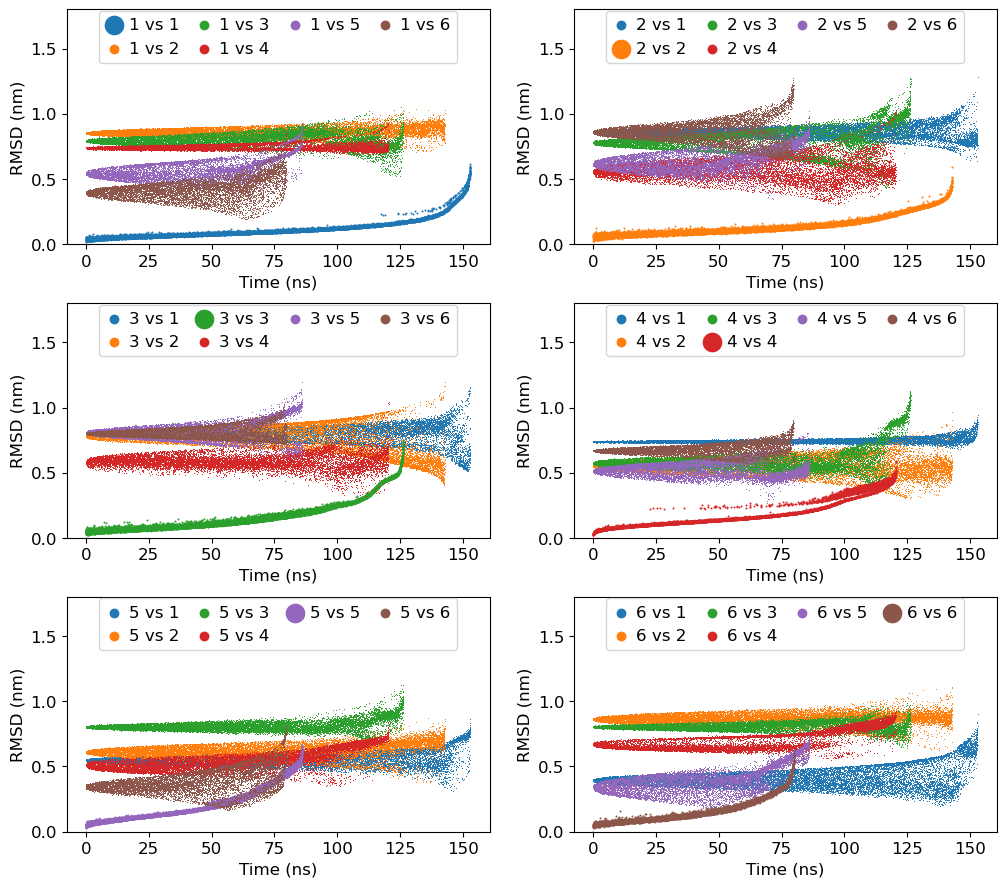

In [17]:
mpl.rcParams['font.size']=12
fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(top=0.98, bottom=0.05, hspace=0.25)

for i in range(1,7):
    
    ax = fig.add_subplot(4, 2, i)
    
    for j in range(1,7):
        filename = 'clustered-rmsd/c{0}_c{1}.xvg'.format(i, j)
        label = "{0} vs {1}".format(i, j)
        data = read_xvg(filename) # read file
        if i==j:
            ax.scatter(data[0]/1000, data[1], label=label, lw=0, s=2)
        else:
            ax.scatter(data[0]/1000, data[1], label=label, lw=0, s=0.5)
        
    ax.set_ylim(0, 1.8)
    ax.set_xlabel('Time (ns)')
    ax.set_ylabel('RMSD (nm)')
    plt.legend(loc='upper center', ncol=4, markerscale=10, borderaxespad=0.1, columnspacing=1, handlelength=1, handletextpad=0.4)
    

plt.savefig('rmsd-comparison.png', dpi=300)
plt.show()

#### Plotting PC vs PC cluster-wise

It will be done in two steps:

1. An input file will be prepared containing information about feature searial and their labels.
2. `gmx_clusterByFeatures featuresplot` will be used to generate the plot.

In [22]:
%%bash

# First step - preparation of input file
echo "1,2,PC-1,PC-2" > features-label.txt
echo "2,3,PC-2,PC-3" >> features-label.txt
echo "1,3,PC-1,PC-3" >> features-label.txt
echo "1,4,PC-1,PC-4" >> features-label.txt
cat features-label.txt

# Second step - plotting
gmx_clusterByFeatures featuresplot -i features-label.txt -feat proj.xvg -clid clid.xvg -o ligand-pca-PCs-vs-PCs.png

1,2,PC-1,PC-2
2,3,PC-2,PC-3
1,3,PC-1,PC-3
1,4,PC-1,PC-4


<img src="ligand-pca-PCs-vs-PCs.png" width="650"/>

#### Cluster-ID with time
We will use `clid.xvg` obtained from the `cluster` subcommand to plot both cluster-id and also highlight the occurance of the given cluster. 

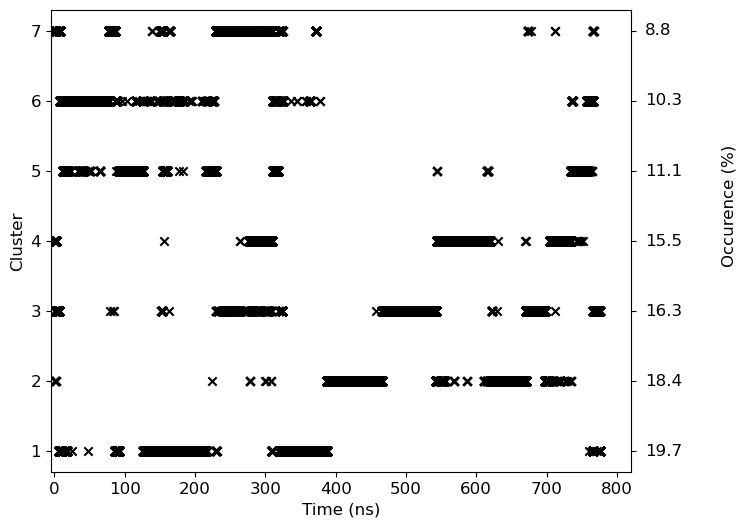

In [21]:
# Occurance has been calculated manually from the data obtained in cluster.log file
occur=[ 19.7, 18.4, 16.3, 15.5, 11.1, 10.3, 8.8]

mpl.rcParams['font.size']=12

data=read_xvg('clid.xvg')
fig = plt.figure(figsize=(8,6))
fig.subplots_adjust(right=0.85)

ax = fig.add_subplot(111)
ax.scatter(data[0]/1000, data[1], marker='x', color='k')
ax.tick_params(axis='y', right=True)

ax.set_ylabel('Cluster')
ax.set_xlabel('Time (ns)')
ax.set_xlim(-5, 820)
for i in range(7):
    ax.text(840, i+1, '{0:3.1f}'.format(occur[i]), verticalalignment='center')
ax.text(960, 4.5, 'Occurence (%)', verticalalignment='center', rotation='vertical', horizontalalignment='center')

plt.savefig('clid.png', dpi=300)
plt.show()